# To Do
- [x] better training visualization
- [x] Make PrototypicalNetwork an nn.Module
- [ ] remove fast_adapt to something more standard
- [ ] add encoder_fit
- [ ] run experiments on dataset and compare with prototypical networks
- [ ] replace matplotlib with plotly
- [ ] add tensorboard

In [1]:
# from plotly.subplots import make_subplots
# import plotly.graph_objects as go
# sample = mode_loader.dataset.sample()
# fig = make_subplots(rows=1, cols=2)
# fig.add_trace(go.Image(z=sample[0][0].numpy().T, name="a"), 1, 1)
# fig.add_trace(go.Image(z=sample[0][1].numpy().T, name="a"), 1, 2)

# imports

In [2]:
import os
import pickle
import random
import math
from functools import partial
from typing import Optional, Callable

import gdown
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader

import learn2learn as l2l
from learn2learn.data.transforms import NWays, KShots, LoadData, RemapLabels

import matplotlib.pyplot as plt

from prototypical_network import ClassificationDataset, PrototypicalNetwork, Convnet

state = 42
torch.manual_seed(state)
torch.cuda.manual_seed(state)
np.random.seed(state)
random.seed(state)
torch.backends.cudnn.enabled=False
torch.backends.cudnn.deterministic=True

/home/woreom/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def download_from_gdrive(_id: str, output: str) -> None:
    gdown.download(id= _id, output= output)

def get_mini_magenet(root: str, mode: str, transform: Optional[Callable] = None, download: bool= False,
                     target_transform: Optional[Callable] = None) -> torch.utils.data.Dataset:
    """Mini ImageNet Dataset Loader for torch"""
    
    gdrive_id = {"test":'1wpmY-hmiJUUlRBkO9ZDCXAcIpHEFdOhD', "train":'1I3itTXpXxGV68olxM5roceUMG8itH9Xj',
                 "val":'1KY5e491bkLFqJDp0-UWou3463Mo8AOco'}
    
    pickle_file = os.path.join(root, f'mini-imagenet_{mode}.pkl')
    
    # download pkl file
    if not os.path.exists(pickle_file) and download:
        print(f"Downloading mini-imagenet_{model} at {pickle_file}")
        download_from_gdrive(_id=MiniImagenet.gdrive_id[mode], output=pickle_file)
        
    # open pkl file
    with open(pickle_file, 'rb') as f:
        data = pickle.load(f)
    
    # create X and y
    X = torch.from_numpy(data["image_data"]).permute(0, 3, 1, 2).float()
    y = np.ones(X.shape[0])

    # dict of indexes to np.array
    for (i, key) in enumerate(data['class_dict'].keys()):
        for idx in data['class_dict'][key]:
            y[idx] = i

    return ClassificationDataset(X= X, y= y, transform= transform,
                                 target_transform= target_transform)

def check_loader(dataset: torch.utils.data.Dataset, grid_split: int= 10, num_img: int= 30) -> None:
    sample = dataset.sample()
    fraction = math.ceil(num_img/grid_split)
    width = grid_split if fraction != 0 else num_img
    height = fraction if  width == grid_split else 1

    figure = plt.figure(figsize=(width, height))
    for i, img in enumerate(sample[0]):
        if i==0: print(f"image.shape: {img.shape}")
        elif i>=num_img: break
        
        figure.add_subplot(height, width, i+1)
        plt.title(sample[1][i].numpy(), fontsize=4)
        plt.axis("off")
        plt.imshow(img[0].numpy(), cmap="gray")

image.shape: torch.Size([3, 96, 96])


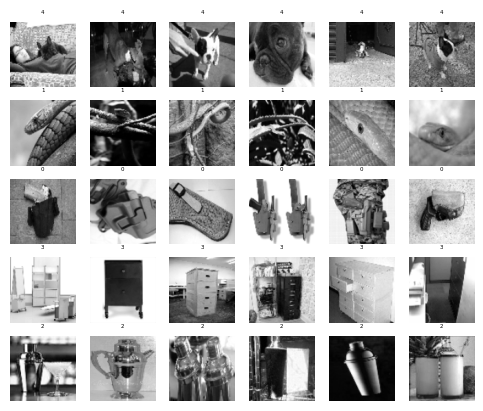

In [4]:
transform = transforms.Compose([
    transforms.Resize((96,96)),
    ])

dataset = get_mini_magenet(mode= 'train', root="../../datasets/mini_imagenet_temp/",
                      transform=transform, target_transform=None, download=False)   

mode_dataset = l2l.data.MetaDataset(dataset)
mode_transforms = [
    NWays(mode_dataset, 5),
    KShots(mode_dataset, 1+5),
    LoadData(mode_dataset),
    RemapLabels(mode_dataset),
]

mode_tasks = l2l.data.TaskDataset(mode_dataset, task_transforms=mode_transforms,
                                  num_tasks= max(dataset.y))

mode_loader = DataLoader(mode_tasks, pin_memory=True, shuffle=True, )
check_loader(dataset= mode_loader.dataset, grid_split= 6, num_img= 50)

# Test

In [5]:
class FlattenResNet(nn.Module):
    def __init__(self,):
        super().__init__()
        autoencoder = torch.load("../outputs/exported/resnet_autoencoder/autoencoder_withouthist.pt")
        self.encoder = autoencoder.encoder
        
    def forward(self, x):
        # print(x.shape)
        return torch.flatten(self.encoder(x), start_dim=1)

In [6]:
for _ in range(1):
    print(f"\n ================== New Test ================== \n")
    torch.cuda.empty_cache()
    transform = transforms.Compose([
        transforms.Resize((96,96)),
        ])

    get_dataset = partial(get_mini_magenet, root="../../datasets/mini_imagenet_temp/",
                        transform=transform, target_transform=None, download=False)

    autoencoder = FlattenResNet()

    model = PrototypicalNetwork(encoder= autoencoder)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    #divide the learning rate by 2 at each epoch, as suggested in paper
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10**6, gamma=0.5, last_epoch=-1)
    loss = F.cross_entropy

    model.fit(get_dataset=get_dataset, epochs= 5, train_num_episode=10000, test_num_episode= 10000,
              train_way= 5, train_shot= 5, train_query= 15, test_way= 5, test_shot= 5, test_query= 15,
              eval_step= 1, early_stop= True, optimizer= optimizer, lr_scheduler=lr_scheduler, loss= loss,)
    torch.cuda.empty_cache()



 ================== New Test ================== 



Epoch 1: 100%|██████████| 10000/10000 [21:34<00:00,  7.73episode/s, acc=(0.585, 0.006), loss=(1.3053, 0.0066), mode=val]


best acc: (0.585, 0.0064), loss: (1.305, 0.0066)
              precision    recall  f1-score   support

         0.0       0.46      0.44      0.45     81615
         1.0       0.54      0.63      0.58     58050
         2.0       0.60      0.71      0.65     80145
         3.0       0.60      0.50      0.54     49860
         4.0       0.50      0.69      0.58     31140
         5.0       0.50      0.60      0.54     19005
         6.0       0.59      0.67      0.63     38475
         7.0       0.72      0.65      0.68     70470
         8.0       0.45      0.31      0.37     30135
         9.0       0.81      0.76      0.78     31125
        10.0       0.47      0.47      0.47     20040
        11.0       0.63      0.55      0.59     49605
        12.0       0.45      0.43      0.44     59355
        13.0       0.48      0.52      0.50     40710
        14.0       0.78      0.61      0.69     60255
        15.0       0.80      0.91      0.85     30015

    accuracy                   

100%|██████████| 10000/10000 [21:33<00:00,  7.73episode/s, acc=(0.595, 0.006), loss=(1.3069, 0.0044), mode=test]


best acc: (0.595, 0.0057), loss: (1.307, 0.0044)
              precision    recall  f1-score   support

         0.0       0.61      0.73      0.67     40635
         1.0       0.59      0.45      0.51     23370
         2.0       0.64      0.61      0.63     55305
         3.0       0.49      0.47      0.48     30900
         4.0       0.60      0.49      0.54     54915
         5.0       0.61      0.58      0.59     24150
         6.0       0.57      0.78      0.66     22620
         7.0       0.60      0.64      0.62     23190
         8.0       0.51      0.66      0.58     32025
         9.0       0.70      0.74      0.72     70695
        10.0       0.61      0.54      0.58     39585
        11.0       0.46      0.40      0.43     33360
        12.0       0.57      0.47      0.52     31290
        13.0       0.41      0.41      0.41     31560
        14.0       0.53      0.59      0.56     39105
        15.0       0.78      0.80      0.79     32490
        16.0       0.63      0.7

Epoch 2: 100%|██████████| 10000/10000 [21:33<00:00,  7.73episode/s, acc=(0.619, 0.007), loss=(1.2721, 0.0060), mode=val]


best acc: (0.619, 0.0066), loss: (1.272, 0.006)
              precision    recall  f1-score   support

         0.0       0.48      0.47      0.48    160965
         1.0       0.56      0.66      0.60    118335
         2.0       0.63      0.73      0.68    159990
         3.0       0.65      0.54      0.59    100890
         4.0       0.50      0.68      0.57     60705
         5.0       0.51      0.56      0.53     39150
         6.0       0.59      0.65      0.62     78405
         7.0       0.72      0.68      0.70    139890
         8.0       0.50      0.38      0.43     60990
         9.0       0.82      0.77      0.79     60990
        10.0       0.47      0.47      0.47     39855
        11.0       0.64      0.59      0.62     99705
        12.0       0.47      0.46      0.46    119190
        13.0       0.51      0.50      0.51     80940
        14.0       0.79      0.60      0.68    120225
        15.0       0.77      0.91      0.84     59775

    accuracy                    

100%|██████████| 10000/10000 [21:34<00:00,  7.72episode/s, acc=(0.623, 0.008), loss=(1.2764, 0.0078), mode=test]


best acc: (0.623, 0.0079), loss: (1.276, 0.0078)
              precision    recall  f1-score   support

         0.0       0.63      0.67      0.65     78705
         1.0       0.64      0.54      0.58     48060
         2.0       0.63      0.64      0.64    109725
         3.0       0.57      0.52      0.54     62955
         4.0       0.57      0.48      0.52    110385
         5.0       0.61      0.64      0.63     48240
         6.0       0.61      0.77      0.68     47100
         7.0       0.60      0.71      0.65     46725
         8.0       0.52      0.66      0.58     62400
         9.0       0.69      0.76      0.72    142455
        10.0       0.58      0.54      0.56     78555
        11.0       0.43      0.37      0.40     65055
        12.0       0.62      0.52      0.57     62790
        13.0       0.47      0.45      0.46     63885
        14.0       0.58      0.60      0.59     79050
        15.0       0.82      0.78      0.80     63120
        16.0       0.68      0.7

Epoch 3: 100%|██████████| 10000/10000 [21:28<00:00,  7.76episode/s, acc=(0.646, 0.007), loss=(1.2569, 0.0058), mode=val]


best acc: (0.646, 0.0068), loss: (1.257, 0.0058)
              precision    recall  f1-score   support

         0.0       0.51      0.51      0.51    241530
         1.0       0.56      0.66      0.61    178095
         2.0       0.64      0.74      0.69    239445
         3.0       0.69      0.57      0.62    151065
         4.0       0.52      0.70      0.60     91005
         5.0       0.52      0.57      0.54     58320
         6.0       0.60      0.61      0.61    119040
         7.0       0.76      0.71      0.73    210120
         8.0       0.51      0.40      0.45     91155
         9.0       0.84      0.79      0.82     91350
        10.0       0.53      0.50      0.51     59355
        11.0       0.66      0.60      0.63    150000
        12.0       0.48      0.47      0.48    178365
        13.0       0.52      0.51      0.52    120465
        14.0       0.75      0.59      0.66    180840
        15.0       0.79      0.90      0.84     89850

    accuracy                   

100%|██████████| 10000/10000 [21:22<00:00,  7.79episode/s, acc=(0.631, 0.006), loss=(1.2623, 0.0054), mode=test]


              precision    recall  f1-score   support

         0.0       0.61      0.69      0.65    119235
         1.0       0.66      0.54      0.60     72120
         2.0       0.64      0.67      0.65    164835
         3.0       0.55      0.49      0.52     95040
         4.0       0.57      0.45      0.50    164445
         5.0       0.62      0.65      0.64     71895
         6.0       0.59      0.78      0.68     70770
         7.0       0.60      0.69      0.64     71175
         8.0       0.51      0.65      0.57     93060
         9.0       0.71      0.78      0.74    212910
        10.0       0.59      0.55      0.57    117270
        11.0       0.46      0.39      0.42     96330
        12.0       0.62      0.53      0.57     94665
        13.0       0.50      0.46      0.48     96315
        14.0       0.58      0.62      0.60    119025
        15.0       0.80      0.78      0.79     94755
        16.0       0.69      0.76      0.72    165015
        17.0       0.74    

Epoch 4: 100%|██████████| 10000/10000 [21:25<00:00,  7.78episode/s, acc=(0.657, 0.006), loss=(1.2361, 0.0056), mode=val]


best acc: (0.657, 0.0063), loss: (1.236, 0.0056)
              precision    recall  f1-score   support

         0.0       0.51      0.53      0.52    321585
         1.0       0.59      0.68      0.63    239475
         2.0       0.65      0.74      0.69    318420
         3.0       0.69      0.57      0.63    201765
         4.0       0.54      0.71      0.62    119040
         5.0       0.53      0.60      0.56     78765
         6.0       0.62      0.61      0.61    159915
         7.0       0.76      0.72      0.74    278880
         8.0       0.53      0.42      0.47    119565
         9.0       0.83      0.80      0.82    121815
        10.0       0.55      0.51      0.53     80070
        11.0       0.68      0.63      0.65    200235
        12.0       0.50      0.48      0.49    239025
        13.0       0.52      0.52      0.52    158625
        14.0       0.73      0.60      0.66    241665
        15.0       0.80      0.90      0.85    121155

    accuracy                   

100%|██████████| 10000/10000 [21:23<00:00,  7.79episode/s, acc=(0.653, 0.005), loss=(1.2465, 0.0048), mode=test]


              precision    recall  f1-score   support

         0.0       0.61      0.71      0.66    157740
         1.0       0.66      0.57      0.61     96735
         2.0       0.65      0.70      0.67    220365
         3.0       0.58      0.51      0.54    126795
         4.0       0.58      0.46      0.51    219750
         5.0       0.63      0.67      0.65     95205
         6.0       0.62      0.80      0.70     93510
         7.0       0.62      0.71      0.66     94575
         8.0       0.53      0.65      0.59    123960
         9.0       0.70      0.79      0.74    283920
        10.0       0.59      0.54      0.57    157395
        11.0       0.49      0.42      0.45    128400
        12.0       0.63      0.53      0.58    125370
        13.0       0.54      0.49      0.51    128475
        14.0       0.57      0.60      0.59    159390
        15.0       0.80      0.78      0.79    124950
        16.0       0.71      0.76      0.73    220725
        17.0       0.72    

Epoch 5: 100%|██████████| 10000/10000 [21:27<00:00,  7.77episode/s, acc=(0.657, 0.006), loss=(1.2391, 0.0062), mode=val]


              precision    recall  f1-score   support

         0.0       0.53      0.53      0.53    401445
         1.0       0.60      0.68      0.64    298965
         2.0       0.64      0.74      0.69    398520
         3.0       0.70      0.59      0.64    251715
         4.0       0.54      0.72      0.62    149160
         5.0       0.54      0.60      0.57     98685
         6.0       0.62      0.61      0.61    199170
         7.0       0.77      0.72      0.74    348780
         8.0       0.54      0.45      0.49    150285
         9.0       0.85      0.81      0.83    151065
        10.0       0.57      0.52      0.54    100500
        11.0       0.68      0.65      0.66    250080
        12.0       0.51      0.47      0.49    300315
        13.0       0.53      0.53      0.53    199725
        14.0       0.74      0.60      0.66    300615
        15.0       0.80      0.90      0.85    150975

    accuracy                           0.63   3750000
   macro avg       0.63   

100%|██████████| 10000/10000 [21:24<00:00,  7.78episode/s, acc=(0.647, 0.006), loss=(1.2521, 0.0052), mode=test]


              precision    recall  f1-score   support

         0.0       0.62      0.70      0.66    196725
         1.0       0.66      0.59      0.62    121050
         2.0       0.66      0.71      0.68    276255
         3.0       0.58      0.50      0.53    156810
         4.0       0.58      0.46      0.51    275460
         5.0       0.64      0.68      0.66    118215
         6.0       0.63      0.81      0.71    117255
         7.0       0.63      0.73      0.68    117585
         8.0       0.54      0.64      0.59    154755
         9.0       0.71      0.79      0.75    355815
        10.0       0.59      0.54      0.56    197070
        11.0       0.50      0.44      0.47    159405
        12.0       0.62      0.54      0.58    157470
        13.0       0.54      0.52      0.53    160155
        14.0       0.57      0.60      0.59    199590
        15.0       0.78      0.76      0.77    157710
        16.0       0.71      0.76      0.74    274875
        17.0       0.73    

100%|██████████| 10000/10000 [21:20<00:00,  7.81episode/s, acc=(0.647, 0.006), loss=(1.2517, 0.0050), mode=test]

best acc: (0.657, 0.0063), loss: (1.236, 0.0056)


In [7]:
model = torch.load("../outputs/exported/PrototypicalNetwork/0.29100000858306885_model.pt")
batch = PrototypicalNetwork.extract_sample(data_loader= mode_loader, ways= 5,
                                                           shot= 5, query_num=1, device='cuda')
support_set, support_classes, query_set, query_classes = batch
logits = model(support_set= support_set, support_classes= support_classes, query_set=query_set,
                                       ways=5, shot= 5, query_num= 1, metric=None, device="cdua")TO



SyntaxError: invalid syntax (3265078295.py, line 6)

In [ ]:
torch.exp(logits)

tensor([[0.7352, 0.3933, 0.7112, 0.5377, 0.0363],
        [0.6002, 0.2414, 0.4831, 0.3018, 0.0085],
        [0.6302, 0.1003, 0.4172, 0.3344, 0.0077],
        [0.5478, 0.1549, 0.3540, 0.3081, 0.0165],
        [0.0060, 0.0883, 0.0259, 0.0569, 0.2154]], device='cuda:0',
       grad_fn=<ExpBackward0>)

In [ ]:
torch.exp(logits).sum(dim=1)

tensor([2.4138, 1.6350, 1.4898, 1.3813, 0.3925], device='cuda:0',
       grad_fn=<SumBackward1>)

In [ ]:
torch.exp(logits) / torch.exp(logits).sum(dim=1).unsqueeze(1)

tensor([[0.3046, 0.1629, 0.2947, 0.2228, 0.0151],
        [0.3671, 0.1476, 0.2955, 0.1846, 0.0052],
        [0.4230, 0.0673, 0.2800, 0.2245, 0.0052],
        [0.3966, 0.1122, 0.2563, 0.2231, 0.0119],
        [0.0153, 0.2249, 0.0661, 0.1449, 0.5488]], device='cuda:0',
       grad_fn=<DivBackward0>)

In [ ]:
i=0
j=4
f"{torch.exp(logits)[i,j]}/{torch.exp(logits).sum(dim=1)[i]}= {torch.exp(logits)[i,j]/torch.exp(logits).sum(dim=1)[i]}"

'0.03633665293455124/2.4137613773345947= 0.015053953975439072'

In [ ]:
from prototypical_network import mle
mle(np.random.randint(low=0, high=10, size=(50)),)

(4.84, 0.26150712)